# Course Project

## 1. Regression

We will consider both regression and classification problems.


### Data simulation

The simulated data is distributed as follows:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim N(\omega^Tx, \sigma^2), \quad \sigma^2=1
$$

Where $p$ is the total number of variables (we use $p=100$), $\omega$ are the weights and $R$ is the correlation matrix. 

The variables are separated in group of 5. In each group, $x_j$ has mean zero, variance 1, and correlation $\rho$ with the other variables of the group. $x_j$ is uncorrelated with the variables outside this group. This means that the correlation matrix $R$ is of the form:

$$
R = \begin{pmatrix} 
  \tilde{R}     & 0 & \cdots & 0\\ 
  0 & \tilde{R} & \cdots & 0\\
  \vdots & \cdots & \tilde{R} & 0 \\
  0 & \cdots & \cdots & \tilde{R}
\end{pmatrix}, \quad \tilde{R} = 
\begin{pmatrix}
1 & \rho & \rho & \rho & \rho\\
\rho & 1 & \rho & \rho & \rho \\
\rho & \rho & 1 & \rho & \rho \\
\rho & \rho & \rho & 1 & \rho \\
\rho & \rho & \rho & \rho & 1 
\end{pmatrix}
$$

The weights are of the form:

$$
\begin{pmatrix}
\omega^{1:5}\\
\omega^{6:10}\\
\omega^{11:15}\\
\omega^{16:p}
\end{pmatrix} = 
\begin{pmatrix}
\chi\\
0.5\chi\\
0.25\chi\\
0
\end{pmatrix}
$$

Where $\omega^{1:5}$ denotes the weights of variables $x_1, \cdots, x_5$. That is, there are 15 variables which are informative to the variable $y$, and $p-15$ variables which are uninformative. 

We perform different experiments varying the training size and the correlation coefficient:

$$
n \in \{100,200,400\} \\
\rho \in \{0, 0.5, 0.9\}\\
\chi \in \{0.59, 0.34, 0.28\}
$$

In [1]:
library(MASS)

In [2]:
simulate.regression<-function(n, rho, chi, p=100){
    sigma2<-1
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rnorm(n, x%*%w, sigma2)
    
    return(list('x' = x,'y' = y))
}

In [3]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 20
chi <- 0.34

# Simulate observations
sim<-simulate.regression(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a linear regression. We will consider the standard Gaussian model:

$$
y|x, \omega, \sigma^2 \sim N(\omega^Tx, \sigma^2)\\
\omega | \sigma^2 \sim N(0, \sigma^2 \mathbb{1})\\
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)\\
$$

In this case we will use $\alpha = \beta =0.5$, and we assume that $x$ includes the intercept. We will fit this model using two approaches: by deriving analytically the posterior distribution and using Stan.



### Formulating the model analytically

The regression model using a normal-inverse-gamma (NIG) prior is a conjugate model. Therefore, the posterior distribution and posterior predictive distribution can be obtained analytically. Here we describe the Bayesian model.

#### Prior

The prior distributions of $\omega$ and $\sigma^2$ are the following:

$$
\omega | \sigma^2 \sim N(0, \sigma^2 \mathbb{1})\\
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)\\
$$

Recall that the joint prior is of the form $p(\omega, \sigma^2) \propto p(\omega|\sigma^2)p(\sigma^2)$. Therefore, the joint prior $(\omega,\sigma^2)$ follows a normal-inverse-gamma (NIG) with parameters:

$$
(\omega,\sigma^2) \sim NIG(0,\mathbb{1},\alpha, \beta)
$$

Finally, the prior distribution of $\omega$ can be found by integrating out $\sigma^2$ from the joint distribution. After some algebra, the resulting prior for $\omega$ is a multivariate student $t$:

$$
\omega \sim MVT_\nu(0, \Sigma)
$$

where $\nu = 2\alpha$ and $\Sigma = \frac{\beta}{\alpha}\mathbb{1}$.

#### Likelihood

The likelihood for the targets $y$ is a normal distribution:
$$
y|x, \omega, \sigma^2 \sim N(\omega^Tx, \sigma^2)\\
$$

#### Posterior

The posterior distribution of the pair $(\omega,\sigma^2)$ can be derived using the Bayes formula:

$$
p(\omega, \sigma|y,x) = \frac{p(\omega, \sigma^2)p(y|\omega,\sigma, x)}{p(y)}
$$

The posterior probability is again a normal-inverse-gamma:

$$
(\omega, \sigma^2|y,x) \sim NIG(\mu^*,V^*,\alpha^*,\beta^*)
$$

with

$$
\mu^* = (\mathbb{1} + X^TX)^{-1}(X^Ty)\\
V^* = (\mathbb{1} + X^TX)^{-1}\\
\alpha^* = \alpha + n/2\\
\beta^* = \beta + \frac{1}{2}(y^Ty - {\mu^*}^T{V^*}^{-1}\mu^*)
$$

The marginal distributions are:

$$
\sigma^2|y,x \sim IG(\alpha^*, \beta^*)\\
\omega|y,x \sim MVT_{\nu^*}(\mu^*, \Sigma^*), \quad \nu^* = 2\alpha^*, \Sigma^* = \frac{\beta^*}{\alpha^*} V^*\\
\omega|\sigma^2,y,x \sim N(\mu^*, \sigma^2V^*)
$$

#### Posterior predictive

Given a new set of observations $\tilde{X}$, the probability distribution of the new targets $\tilde{y}$ follows a multivariate student t distribution:

$$
    \tilde{y}|x,y,\sigma^2, \omega \sim MVT_{2\alpha^*}\Big(\tilde{X}\mu^*, \frac{\beta^*}{\alpha^*}(\mathbb{1} + \tilde{X}V^*\tilde{X}^T)\Big)
$$

In [4]:
require('LaplacesDemon')
require(invgamma)

Loading required package: LaplacesDemon

Loading required package: invgamma


Attaching package: ‘invgamma’


The following objects are masked from ‘package:LaplacesDemon’:

    dinvchisq, dinvgamma, rinvchisq, rinvgamma




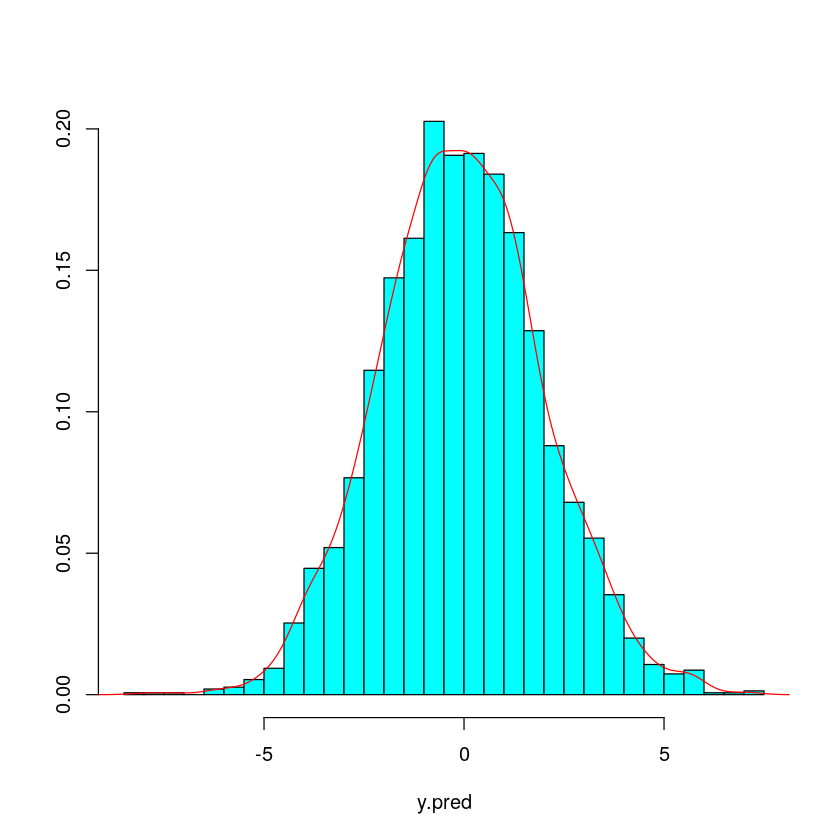

In [5]:
# Define parameters
n <- 100
rho <- 0.5
p <- 20
chi <- 0.34

# Initial parameters
alpha <- 0.5
beta <- 0.5
N<-3000

# Train and test data sets
# Train set
sim.train<-simulate.regression(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y
x.train.ext<-cbind(rep(1, dim(x.train)[2]),x.train)

# Test set
sim.test<-simulate.regression(N, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y
x.test.ext<-cbind(rep(1, dim(x.test)[2]),x.test)

# Posterior parameters
V.s<-round(solve(diag(p+1) + t(x.train.ext)%*%x.train.ext),10)
mu.s<-V.s%*%(t(x.train.ext)%*%y)
alpha.s<-alpha + n/2
beta.s<-as.numeric(beta + 1/2*(t(y)%*%y - t(mu.s)%*%solve(V.s)%*%mu.s))

# Sample from posterior 
sigma2.post<-rinvgamma(N,alpha.s,beta.s)
omega.post<- rmvt(N,mu.s, V.s, df=2*alpha.s)#rmvt(N,delta = mu.s,sigma = V.s, df = 2*alpha.s)

# Sample from posterior predictive
new.x<-x.test.ext[1,]
new.mu<-new.x%*%mu.s
new.V<-beta.s/alpha.s*(diag(1) + t(new.x)%*%V.s%*%new.x)
y.pred<-rmvt(N, new.mu, new.V, df = 2*alpha.s)

# Get probability density posterior predictive
new.y<-as.matrix(seq(-10,10,0.001))
dens<-density(y.pred)
y.dens <- approx(dens$x,dens$y,xout=new.y)$y


truehist(y.pred)
lines(new.y, y.dens, col="red")

In [6]:
fit.reg.analytical<-function(x.train, y.train, alpha, beta, extended=FALSE){
    p<-dim(x.train)[2]
    if(!extended){
        x.train.ext<-cbind(dim(x.train)[1],x.train)
        p<-p+1
    }
    else{
        x.train.ext<-x.train
    }
    # Posterior parameters
    V.s<-round(solve(diag(p) + t(x.train.ext)%*%x.train.ext),10)
    mu.s<-V.s%*%(t(x.train.ext)%*%y.train)
    alpha.s<-alpha + n/2
    beta.s<-as.numeric(beta + 1/2*(t(y.train)%*%y.train - t(mu.s)%*%solve(V.s)%*%mu.s))
    return(list(V.s =V.s, mu.s = mu.s, alpha.s = alpha.s, beta.s = beta.s))

}

get.prob.y.reg.anal<-function(x.new, V.s, mu.s, alpha.s,beta.s, probs, extended = FALSE){
    # Sample from posterior predictive
    if(!extended){
        x.new.ext<-rbind(1,x.new)
    }
    else{
        x.new.ext<-x.new
    }
    new.mu<-t(x.new.ext)%*%mu.s
    new.V<-beta.s/alpha.s*(diag(1) + t(x.new.ext)%*%V.s%*%x.new.ext)
    y.pred<-rmvt(N, new.mu, new.V, df = 2*alpha.s)

    # Get probability density posterior predictive
    new.y<-as.matrix(seq(-10,10,0.001))
    dens<-density(y.pred)
    y.dens <- approx(dens$x,dens$y,xout=probs)$y
    return(y.dens)
}

fit<-fit.reg.analytical(x.train, y.train, alpha, beta)
x.new<-as.matrix(x.test[1,])
probs<-seq(-5,5,0.01)
dens<-get.prob.y.reg.anal(x.new, fit$V.s, fit$mu.s, fit$alpha.s,fit$beta.s, probs)


### Formulating the model with Stan

In [7]:
modelString.reg = "
   data { 
      int<lower=1> n;   // total number of observations 
      vector[n] y;      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaS;    // alpha sigma^2
      real betaS;    // beta sigma^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> sigma;   // standard deviation y
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,sigma);
      sigma ~ inv_gamma(alphaS, betaS);

      // likelihood 
      y ~ normal(mu, sigma); 
      } 
      
   generated quantities {
      } 
"

### Generate data for the model


In [8]:
D <- data.frame(y, x)

X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model

data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                             alphaS=0.5, betaS=0.5, alphaT=0.5, betaT=0.5))



### Fitting the model

In [9]:
#install.packages("rstan",dependencies=TRUE,repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



### Generate a sample from the posterior probability

In [10]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code=modelString.reg) 

# Generate posterior sample:
stanFit.post<-sampling(object=stanDso,data=data.list,chains=1,iter=10000,warmup=1500,thin=1, seed =101)


SAMPLING FOR MODEL 'e5fbc3392bc853139e89e4496de18608' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1501 / 10000 [ 15%]  (Sampling)
Chain 1: Iteration: 2500 / 10000 [ 25%]  (Sampling)
Chain 1: Iteration: 3500 / 10000 [ 35%]  (Sampling)
Chain 1: Iteration: 4500 / 10000 [ 45%]  (Sampling)
Chain 1: Iteration: 5500 / 10000 [ 55%]  (Sampling)
Chain 1: Iteration: 6500 / 10000 [ 65%]  (Sampling)
Chain 1: Iteration: 7500 / 10000 [ 75%]  (Sampling)
Chain 1: Iteration: 8500 / 10000 [ 85%]  (Sampling)
Chain 1: Iteration: 9500 / 10000 [ 95%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.234952 seconds (Warm-up)
Chain 1:                1.22883

In [11]:
# Samples of all the variables

omega.post <- extract(stanFit.post, 'omega')$omega
sigma.post <- extract(stanFit.post, 'sigma')
sigma.post <- unlist(sigma.post, use.names=FALSE)

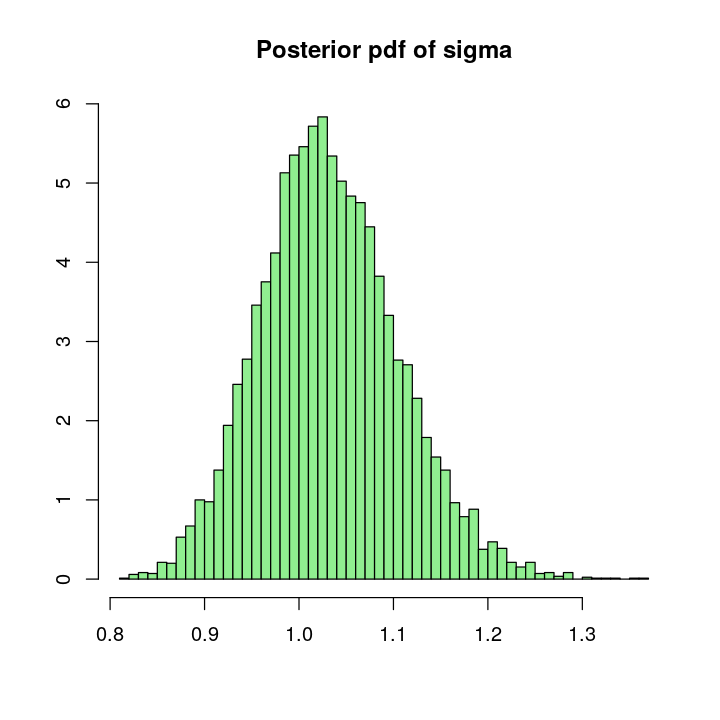

In [12]:
options(repr.plot.width=6,repr.plot.height=6)
hist(sigma.post,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Posterior pdf of sigma")


### Obtain probability distribution of new observations

In [13]:
# Given a new observation x.new
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)
x.new.ext<-rbind(1,x.new)


# Generate the probability distribution y|x,omega,sigma,tau
# Draw samples of y from the likelihood, using the posterior parameters

get.y.distr<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}

y.samp<-get.y.distr(x.new, omega.post, sigma.post)

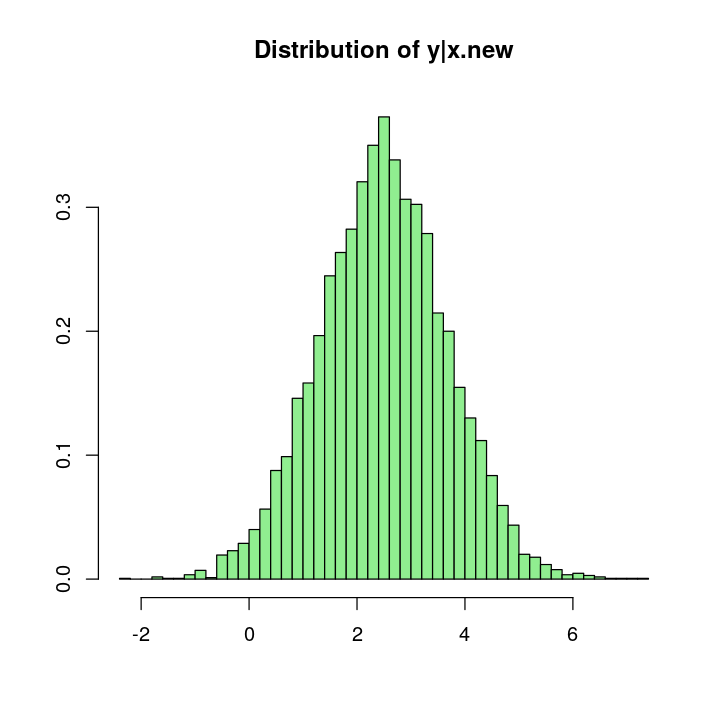

In [14]:
options(repr.plot.width=6,repr.plot.height=6)
hist(y.samp,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Distribution of y|x.new")


## Putting it all together

The following function calculates a Bayesian Linear Regression, given an initial dataset and prior parameters. It returns the posterior quantities. These quantities can be used to generate the labels probability distribution $\tilde{y}|x,\omega,\sigma,\tau$. 


In [8]:
# Load Stan package
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

fit.linear.regression<-function(x,y,alphaS, betaS, modelString){
    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                                 alphaS=alphaS, betaS=betaS))

    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code=modelString) 

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=2000,warmup=1000,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    sigma.post <- extract(stanFit.post, 'sigma')
    sigma.post <- unlist(sigma.post, use.names=FALSE)
    
    return(list(omega.post = omega.post,  sigma.post = sigma.post)) 
}


get.y.distr.reg<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}


get.y.probs.reg<-function(x.new, omega.post, sigma.post, q){
    # q is the vector of quantiles to obtain the probabilities
    y.samp<-get.y.distr.reg(x.new, omega.post, sigma.post)
    dens<-density(y.samp)
    probs <- approx(dens$x,dens$y,xout=q)$y
    return(probs)
}

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [9]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.linear.regression(x,y,0.5,0.5, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

# New observation
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
probs<-get.y.probs.reg(x.new, omega.post, sigma.post, seq(-4,4,0.1))
probs

[1] 1.158552e-03 1.158371e-03 1.041331e-03 9.604976e-04 1.126675e-03
 [6] 1.681370e-03 2.621653e-03 3.816314e-03 5.073783e-03 6.332739e-03
[11] 7.963869e-03 1.073109e-02 1.511225e-02 2.066251e-02 2.629103e-02
[16] 3.134394e-02 3.608669e-02 4.134041e-02 4.802191e-02 5.697361e-02
[21] 6.841628e-02 8.175667e-02 9.633763e-02 1.121992e-01 1.298556e-01
[26] 1.494229e-01 1.697226e-01 1.887432e-01 2.060280e-01 2.242588e-01
[31] 2.463958e-01 2.713946e-01 2.951351e-01 3.160188e-01 3.357512e-01
[36] 3.545103e-01 3.690207e-01 3.770853e-01 3.804758e-01 3.821059e-01
[41] 3.823454e-01 3.797808e-01 3.739542e-01 3.657758e-01 3.551775e-01
[46] 3.396985e-01 3.175072e-01 2.914278e-01 2.672355e-01 2.473661e-01
[51] 2.292032e-01 2.091175e-01 1.867599e-01 1.646110e-01 1.447576e-01
[56] 1.267607e-01 1.089147e-01 9.076469e-02 7.377104e-02 5.947448e-02
[61] 4.820856e-02 3.939292e-02 3.240691e-02 2.661209e-02 2.129280e-02
[66] 1.600061e-02 1.087674e-02 6.574065e-03 3.664302e-03 2.196937e-03
[71] 1.728453e-03 1.704221e-03 1.689959e-03 1.444591e-03 9.926315e-04
[76] 5.291952e-04 2.159801e-04 6.687592e-05 1.563616e-05 3.056364e-06
[81] 2.256359e-06

## 2. Classification model

### Data simulation

The second type of models we are going to consider are Classification models. 
In this case, we will simulate binary data according to a probit model. The data simulation process is the following:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim Ber(\Phi(\omega^Tx))
$$

Where $R$ is the same correlation matrix as the one used in the regression problem, and $\Phi$ is the cumulative distribution function of a Gaussian distribution. The weights $\omega$ and the parameters $n, \rho, \chi, p$ are the same as the ones used in the regression problem.

In [9]:
library(MASS)

simulate.classification<-function(n, rho, chi, p=100){
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rbinom(n,1, pnorm(x%*%w))
    
    return(list('x' = x,'y' = y))
}

In [10]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 100
chi <- 0.34

# Simulate observations
sim<-simulate.classification(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a linear regression. We will consider the standard logistic model:

$$
y|x, \omega \sim Ber(\text{inv_logit}(\omega^Tx))\\
\omega |  \tau^2 \sim N(0, \tau^2 \mathcal{1})\\
\tau^2 \sim \text{Inv-Gamma}(\alpha_\tau, \beta_\tau)
$$

In this case we will use $ \alpha_\tau = \beta_\tau =0.5$, and we assume that $x$ includes the intercept.

We will fit this model using Stan.

### Formulating the model

In [11]:
modelString.class = "
   data { 
      int<lower=1> n;   // total number of observations 
      int<lower=0,upper=1> y[n];      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaT;   // alpha tau^2
      real betaT;    // beta tau^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> tau; // standard deviation omega
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,tau); 
      tau ~ inv_gamma(alphaT, betaT);

      // likelihood 
      y ~ bernoulli_logit(mu);

      } 
      
   generated quantities {
      } 
"

In [40]:
# Load Stan package
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

# Translate model to C++ and compile to DSO:
stanDso.class <- stan_model(model_code=modelString.class)     

fit.probit<-function(x,y, alphaT, betaT, stanDso){

    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                               alphaT=alphaT, betaT=betaT))

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=10000,warmup=1500,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    tau.post <- extract(stanFit.post, 'tau')
    tau.post <- unlist(tau.post, use.names=FALSE)

    return(list(omega.post = omega.post, tau.post = tau.post))    
}


get.y.distr.class<-function(x.new, omega.post){
    x.new.ext<-rbind(1,x.new)
    p<-pnorm(omega.post%*%x.new.ext)
    n.samp<-length(tau.post)
    y.samp<-rbinom(n.samp, 1, p)
    return(y.samp)
}


get.y.probs.class<-function(x.new, omega.post){
    y.samp<-get.y.distr.class(x.new, omega.post)
    p<-sum(y.samp)/length(y.samp)
    return(p)
}


In [41]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.probit(x,y,0.5, 0.5, stanDso.class)
omega.post<-linear.fit$omega.post
tau.post<-linear.fit$tau.post

# New observation
sim.new<-simulate.classification(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
prob<-get.y.probs.class(x.new, omega.post)

prob

Warning message:
“There were 505 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


### Using rstanarm

Alternatively, we can use the rstanarm package to simulate the logistic model

In [ ]:
require(rstanarm)
options(mc.cores = parallel::detectCores())

In [142]:
fit.logit<-function(x.train, y.train, alpha, beta, return.cols = FALSE){
    D <- data.frame(y.train, x.train)
    t_prior <- student_t(df = 2*alpha, location = 0, scale = beta/alpha)

    post<-stan_glm(y.train~ ., data = D,
                 family = binomial(link = "logit"), 
                 prior = t_prior, prior_intercept = t_prior,
                 seed = 123)
    if(return.cols){
        return(list(post = post, names = colnames(D)))
    }
    return(post)
}


pred.prob.class<-function(D.test, model =post, draws=500){
    pred<-posterior_predict(model, D.test, draws = 500)
    p<-sum(pred)/length(pred)
    return(p)
}

## Experiments: Regression

In this section we will perform different experiments to perform variable sellection in a linear regression problem. We will use different criteria, and assess the results.


### Utility function

The predictive performance of a model is typically defined in terms of a utility function that describes the quality of the predictions. An often used utility function measuring the quality of the predictive distribution of the candidate model M is the expected logarithmic score:

$$
u(M) = \mathbb{E}[log(p(\tilde{y}|M,D)] = \int p_t(\tilde{y}) log(p(\tilde{y}|M,D)) d\tilde{y}
$$

Where $D$ is the training dataset, $M$ is the chosen model, $\tilde{y}$ is a new target observation and $p_t(\tilde{y})$ is the true data generation distribution. 

A generalization of the utility function is the mean log predictive density (MLPD):

$$
MLPD = - \frac{1}{\tilde{n}} \sum_{i=1}^{\tilde{n}} log(\tilde{y}|\tilde{x}, D, M)
$$

Where $\{(\tilde{x}, \tilde{y})\}_{i=1}^n$ is the test set. In this case, the best model will be the one which **minimizes** the MLPD.

In [150]:
## Generate data

# Example
# Define parameters
n <- 100
nt<-1000
rho <- 0.5
p <- 30
chi <- 0.34

# Simulate observations
# Train set
sim.train<-simulate.regression(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y

# Test set
sim.test<-simulate.regression(nt, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y

### With STAN

In [17]:
MLPD<-function(x.test, y.test, nt, sigma.pos, omega.pos){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        p<-get.y.probs.reg(as.matrix(x.test[i,]), omega.post, sigma.post, y.test[i])
        MLPD<-MLPD + log(p)
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}

In [18]:
# Get MLPD
# Fit linear model and generate posterior quantities
linear.fit<-fit.linear.regression(x.train,y.train,0.5,0.5, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post


performance<-MLPD(x.test, y.test, nt, sigma.pos, omega.pos)

performance

[1] 1.436887

### Analytically

In [158]:
MLPD.anal<-function(x.test, y.test, nt, V.s, mu.s, alpha.s, beta.s){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        p<-get.prob.y.reg.anal(as.matrix(x.test[i,]), V.s, mu.s, alpha.s, beta.s, y.test[i])
        if(!is.na(p)){
          MLPD<-MLPD + log(p)   
        }
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}


In [167]:
# Get MLPD
# Fit linear model 
fit<-fit.reg.analytical(x.train, y.train, alpha, beta)

performance<-MLPD.anal(x.test, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance


[1] 1.686642

## Optimization process

As a search heuristic we used the standard forward search, also known as the
stepwise regression. In other words, starting from the empty model, at each step we select the variable that increases the utility estimate (like CV, WAIC, DIC, etc.) the most.



In [187]:
optimization<-function(x.train, y.train, criteria, extended = TRUE){
    print("Starting optimization")
    D <- data.frame(y.train, x.train)
    if(extended){
        X.model = model.matrix(y.train~. , data = D)
    }
    else{
        X.model = x.train
    }
    num.vars<-dim(X.model)[2]
    all.vars<-seq(1,num.vars)
    var.list<-c(1)
    all.criteria<-c()
    best.vars<-var.list
    best.crit.val<-1000
    j<-0
    while(length(var.list)<num.vars){
        j<-j+1
        current.x.train<-as.matrix(X.model[,var.list])

        current.crit.val<-criteria(current.x.train, y.train)
        all.criteria<-c(all.criteria, current.crit.val)
        new.crit.vals<-c()
        sel.vars<-all.vars[-var.list]
        
        for(i in sel.vars){
            new.x.train<-as.matrix(X.model[,c(var.list,i)])
            new.crit.val<-criteria(new.x.train, y.train)
            new.crit.vals<-c(new.crit.vals,new.crit.val)
        }
        
        idx<-which.min(new.crit.vals)
        new.var<-sel.vars[idx]
        if(new.crit.vals[idx] < best.crit.val  ){
            best.vars<-c(var.list,new.var)
            best.crit.val<-new.crit.vals[idx]
        }
        var.list<-c(var.list,new.var)
        current.crit.val<-new.crit.vals[idx]
    }
    
    current.x.train<-as.matrix(X.model[,best.vars])
    print(best.vars)
    if(extended){
        return(list(model = current.x.train, num.vars = dim(current.x.train)[2]-1,
                    criteria = best.crit.val, all.criteria = all.criteria))
    }
    D <- data.frame(y.train, current.x.train)
    X.model = model.matrix(y.train~. , data = D)
    return(list(model = X.model, num.vars = dim(current.x.train)[2] -1 ,
                        criteria = best.crit.val,all.criteria = all.criteria))
}

## Criteria 1: Cross-validation

The K-flod cross validation is an approximation of the utility function:

$$
K-fold-CV = \frac{1}{n} \sum_{i=1}^n log(p(y_i|x_i, D_i, M)
$$

where $D_i$ is the training dataset without the point $(x_i, y_i)$ (and probably other sample points). 



### With Stan

In [22]:
library(caret)

k.fold.cv<-function(x.train, y.train, k.fold=10){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        linear.fit<-fit.linear.regression(x.fold.out,y.fold.out,0.5,0.5, modelString.reg)
        omega.post<-linear.fit$omega.post
        sigma.post<-linear.fit$sigma.post
        
        for(j in 1:length(idx)){ 
            p<-get.y.probs.reg(as.matrix(x.fold.in[j,]), omega.post, sigma.post, y.fold.in[j])
            if(!is.na(p)){
                cv<-cv + log(p)
            }
        }
    }
    cv<-cv/length(y.train)
    return(cv)
}

k.fold<-10

cv<-k.fold.cv(x.train, y.train, k.fold)

cv

Loading required package: lattice



[1] -1.585621

### Optimizing CV

In [345]:
opt<-optimization(x.train, y.train, k.fold.cv)

[1] "Starting optimization"
[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13


In [350]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 13

[1] -1.455791

[1] "(Intercept)" "X3"          "X5"          "X6"          "X1"         
 [6] "X12"         "X9"          "X2"          "X8"          "X10"        
[11] "X17"         "X15"         "X20"         "X19"

In [420]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.pos, omega.pos)

performance

[1] 1.579814

### Analytically

In [171]:
library(caret)

k.fold.cv.anal<-function(x.train, y.train, k.fold=10, extended=TRUE){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        fit<-fit.reg.analytical(x.fold.out, y.fold.out, alpha, beta, extended=extended)
        
        for(j in 1:length(idx)){ 
            p<-get.prob.y.reg.anal(as.matrix(x.fold.in[j,]), fit$V.s, 
                                   fit$mu.s, fit$alpha.s, fit$beta.s, 
                                   y.fold.in[j], extended = extended)
            if(!is.na(p)){
                cv<-cv + log(p)
            }
        }
    }
    cv<- - cv/length(y.train)
    return(cv)
}

k.fold<-10

cv<-k.fold.cv.anal(x.train, y.train, k.fold, extended=FALSE)

cv

[1] 1.848086

In [198]:
opt<-optimization(x.train, y.train, k.fold.cv.anal)

[1] "Starting optimization"
[1]  1  6  4  2 16  5  9 13 22


In [199]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 8

[1] 1.58477

[1] "(Intercept)" "X5"          "X3"          "X1"          "X15"        
[6] "X4"          "X8"          "X12"         "X21"

In [200]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
fit<-fit.reg.analytical(x.train.model, y.train, alpha, beta)

performance<-MLPD.anal(x.test.model, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance

[1] 1.594188

## Criteria 2: Reference model approach

The idea of the reference model criteria is to construct a full encompassing reference model $M^∗$, which is believed to best describe our knowledge about the future observations, and perform the utility estimation almost as if it was the true data generating distribution.

Assuming we have constructed a reference model $M^∗$ which we believe best describes our knowledge about the future observations, the utilities of the candidate models $M$ can be estimated by replacing the true distribution $p_t(\tilde{y})$  by the predictive distribution of the reference model $p(\tilde{y} | D, M^∗)$. The maximization of the reference utility is equivalent to minimizing the predictive KL-divergence between the reference model $M^∗$ and the candidate model M at the training inputs:

$$
\delta(M||M^*) = \frac{1}{n}\sum_{i=1}^n KL(p(\tilde{y_i} | x_i, D, M^∗)||p(\tilde{y_i} | x_i, D, M))
$$

The model choice can then be based on the strict minimization of the discrepancy measure, or choosing the simplest model that has an acceptable discrepancy.

The reference predictive approach is inherently a less straightforward approach to model selection than the cross-validation criteria , because it requires the construction of the reference model and it is not obvious how it should be done.  Bayesian model average (BMA) has been commonly proposed as the reference model. In the variable selection context, the model averaging corresponds to a spike-and-slab type prior which is often considered as the “gold standard” and has been extensively used for linear models. The BMA approach is the following:

$$
p(\tilde{y}|D) = \sum_{l=1}^L p(\tilde{y}|D, M_l) p(M_l|D)
$$

where $p(\tilde{y}|D, M_l)$ is the posterior predictive distribution of a fitted model $M_l$ and $p(M_l|D)$ is the prior probability of the certain model $M_l$. 

The package BMS implements the Bayesian Model Average (BMS). We will use this package to generate the reference model.



### Bayesian model average (BMA)

In [188]:
require("BMS")

D <- data.frame(y.train, x.train)
bma<-bms(D, mprior = "random", burn = 20000, iter = 50000, user.int = FALSE)

Loading required package: BMS



Here we can see the statistics of the average model. The PIP quantity indicates the proportion of the models where a certain variable has been used. Variables with high PIP are believed to have hihger importance.

In [189]:
bma

        PIP    Post Mean    Post SD Cond.Pos.Sign Idx
X4  0.94816  0.592190011 0.21968565    1.00000000   4
X1  0.73258  0.435872739 0.30889318    1.00000000   1
X15 0.68272  0.320471312 0.25023250    1.00000000  15
X10 0.64808  0.277229825 0.23395556    1.00000000  10
X3  0.61206  0.272837266 0.25162061    1.00000000   3
X2  0.47104  0.226470542 0.27422147    1.00000000   2
X27 0.34638  0.103007077 0.16005459    1.00000000  27
X6  0.29652  0.109225513 0.19108309    1.00000000   6
X9  0.24826  0.092421700 0.18329052    1.00000000   9
X5  0.17348  0.062861460 0.16013769    1.00000000   5
X13 0.14800  0.040116280 0.11459366    1.00000000  13
X11 0.13960  0.035678314 0.10683060    0.99914040  11
X7  0.12348  0.032055541 0.10285198    1.00000000   7
X17 0.09354  0.017925404 0.06923939    1.00000000  17
X8  0.09234  0.021169751 0.08377497    0.99545159   8
X21 0.08708  0.016210023 0.06636445    1.00000000  21
X14 0.06556 -0.010955956 0.05807752    0.04758999  14
X24 0.06368  0.008543650 0.0

Thi package also allows to give the posterior predictive density of $\tilde{y}|x$, where $x$ is a new observation, and $\tilde{y}$ is the point (or list of points) where we want to evaluate the density. 

We can also visualize the density of the prediction.

In [190]:
D.test <- matrix(x.test[1,], nrow=1)
pdens <- pred.density(bma, newdata = D.test)

0.3084939,0.3088688,0.3092248,0.3095619,0.30988,0.3101792,0.3104592,0.3107201,0.3109619,0.3111843,⋯,2.025989e-06,1.967395e-06,1.910463e-06,1.855147e-06,1.801402e-06,1.749183e-06,1.69845e-06,1.649159e-06,1.601272e-06,1.554749e-06


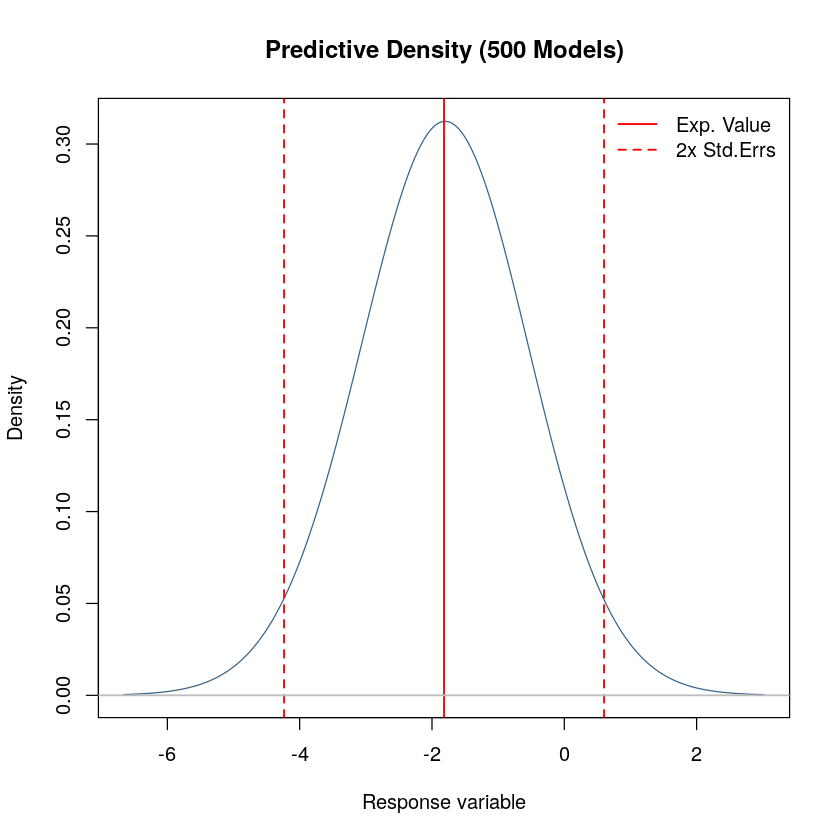

In [191]:
plot(pdens,1)
probs<-seq(-2,5,0.01)
pdens$dyf(probs)

Finally, the package also provides the mean log predictive density (MLPD).

In [192]:
pdens <- pred.density(bma, newdata = x.test)

lps.bma(pdens,matrix(y.test, ncol=1))

[1] 1.546713

### Reference model approach

#### Analytical

In [193]:
reference.model.anal<-function(x.train, y.train, original.x=x.train.data, reference.model = bma, extended = TRUE){  
    fit<-fit.reg.analytical(x.train, y.train, alpha, beta, extended=extended)
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    for(i in 1:dim(x.train)[1]){ 
        # Reference density
        D.train <- matrix(original.x[i,], nrow=1)
        pdens <- pred.density(reference.model, newdata = D.train)
        p.reference<-pdens$dyf(seq.y)
        # Target density
        p.target<-get.prob.y.reg.anal(matrix(x.train[i,]), fit$V.s, 
                                       fit$mu.s, fit$alpha.s, fit$beta.s, 
                                       seq.y, extended = extended)
        # Remove NAN
        idx<-!is.na(p.target) & !is.na(p.reference)
        p.reference<-matrix(p.reference[idx])
        p.target<-matrix(p.target[idx])
        # KL divergence
        KL.new<-KLD(p.reference, p.target)$sum.KLD.px.py
        KL<-KL+KL.new
    }    
    return(KL/n) 
}

x.train.data<-x.train
KL<-reference.model.anal(x.train, y.train, reference.model = bma, extended = TRUE)
KL

[1] 0.1489668

In [207]:
opt<-optimization(x.train, y.train, reference.model.anal)

[1] "Starting optimization"
[1]  1  2  4  5 11 16 20 19 31


In [208]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 8

[1] 0.02238852

[1] "(Intercept)" "X1"          "X3"          "X4"          "X10"        
[6] "X15"         "X19"         "X18"         "X30"

In [211]:
opt$all.criteria

[1] 0.37415841 0.20344432 0.13927582 0.10645795 0.06946764 0.02315909
 [7] 0.02331759 0.02323167 0.02276099 0.02288015 0.02278620 0.02287330
[13] 0.02264933 0.02467362 0.02531703 0.02671414 0.02899135 0.03147787
[19] 0.03451720 0.03488656 0.03618046 0.03798113 0.04398463 0.05664675
[25] 0.05974847 0.06669454 0.07283175 0.08943779 0.11024493 0.11962291

In [212]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
fit<-fit.reg.analytical(x.train.model, y.train, alpha, beta)

performance<-MLPD.anal(x.test.model, y.test, nt, fit$V.s, fit$mu.s, fit$alpha.s, fit$beta.s)

performance

[1] 1.605

#### with STAN

In [67]:
reference.model<-function(x.train, y.train, original.x=x.train.data, reference.model = bma){

    linear.fit<-fit.linear.regression(x.train, y.train, alpha, beta, modelString.reg)
    omega.post<-linear.fit$omega.post
    sigma.post<-linear.fit$sigma.post
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    for(i in 1:dim(x.train)[1]){ 
        # Reference density
        D.train <- matrix(original.x[i,], nrow=1)
        pdens <- pred.density(reference.model, newdata = D.train)
        p.reference<-pdens$dyf(seq.y)
        # Target density
        p.target<-get.y.probs.reg(matrix(x.train[i,]), omega.post, sigma.post, seq.y)
        # Remove NAN
        idx<-!is.na(p.target) & !is.na(p.reference)
        p.reference<-matrix(p.reference[idx])
        p.target<-matrix(p.target[idx])
        # KL divergence
        KL.new<-KLD(p.reference, p.target)$sum.KLD.px.py
        KL<-KL+KL.new
    }    
    return(KL/n) # Negative sign because the optimization process looks for a maxima    
}

x.train.data<-x.train
KL<-reference.model.anal(x.train, y.train, reference.model = bma, extended = TRUE)
KL

[1] 0.2857493

In [ ]:
opt<-optimization(x.train, y.train, reference.model)

In [ ]:
opt$num.vars
opt$criteria
colnames(opt$model)

In [ ]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
linear.fit<-fit.linear.regression(x.train.model, y.train, alpha, beta, modelString.reg)
omega.post<-linear.fit$omega.post
sigma.post<-linear.fit$sigma.post

performance<-MLPD(x.test.model, y.test, nt, sigma.pos, omega.pos)

performance

## Experiments: Classification

### MLDP classification

In [213]:
MLPD.class<-function(x.test, y.test, nt, post){#omega.pos){
    MLPD <- 0
    for(i in 1:nt){
        # Get probability density of different values of y
        D.test<-data.frame(x.test)
        p<-pred.prob.class(D.test[i,])
        #p<-get.y.probs.class(as.matrix(x.test[i,]), omega.post)
        if((p>0)*(p<1)){
            MLPD<-MLPD + log(p) + log(1.-p)
        }
        
    }
    MLPD<- - MLPD/nt
    return(MLPD)
}

In [214]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 30
chi <- 0.34
alpha<-0.5
beta<-0.5
nt<-1000

# Simulate observations
sim.train<-simulate.classification(n, rho, chi, p)
x.train<-sim.train$x
y.train<-sim.train$y

# Simulate observations
sim.test<-simulate.classification(nt, rho, chi, p)
x.test<-sim.test$x
y.test<-sim.test$y

# Get MLPD
# Fit linear model and generate posterior quantities
#linear.fit<-fit.probit(x.train,y.train,alpha,beta, stanDso.class)
#omega.post<-linear.fit$omega.post
post<-fit.logit(x.train,y.train, alpha, beta)

performance<-MLPD.class(x.test, y.test, nt, post)# omega.pos)

performance

[1] 2.490719

## Criteria 1: Cross-validation

In [220]:
library(caret)

k.fold.cv.class<-function(x.train, y.train, k.fold=10){
    set.seed(10)
    partitions<-createFolds(y.train, k = k.fold, list = TRUE, returnTrain = FALSE)
    cv<-0
    for(i in 1:k.fold){
        idx<-unlist(partitions[i])
        x.fold.in<-as.matrix(x.train[idx,])
        y.fold.in<-y.train[idx]
        x.fold.out<-as.matrix(x.train[-idx,])
        y.fold.out<-y.train[-idx]
        #linear.fit<-fit.probit(x.fold.out,y.fold.out,alpha,beta, stanDso.class)
        #omega.post<-linear.fit$omega.post
        post.fit.obj<-fit.logit(x.fold.out,y.fold.out, alpha, beta,return.cols = TRUE)
        post.fit<-post.fit.obj$post
        names<-post.fit.obj$names
        D.test<-data.frame(x.fold.in)
        colnames(D.test) <- colnames(D.test) <- names[2:length(names)]
        for(j in 1:length(idx)){ 
            # Target probability
            if(dim(D.test)[2]>1){
                p<-pred.prob.class(D.test[j,], model = post.fit)
            }
            else{
                p<-pred.prob.class(D.test, model = post.fit)
            }
            #p<-get.y.probs.class(as.matrix(x.fold.in[j,]), omega.post)
            if((p>0)*(p<1)){
                cv<-cv + log(p) + log(1-p)
            }
        }
    }
    cv<- -cv/length(y.train)
    return(cv)
}

k.fold<-10

cv<-k.fold.cv.class(x.train, y.train, k.fold)

cv

[1] 2.756022

In [ ]:
opt<-optimization(x.train, y.train, k.fold.cv.class, extended = FALSE)

In [ ]:
opt$num.vars
opt$criteria
colnames(opt$model)

In [ ]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model,y.train, alpha, beta)
#linear.fit<-fit.probit(x.train.model,y.train,alpha,beta, modelString.class)
#omega.post<-linear.fit$omega.post

performance<-MLPD.class(x.test.model, y.test, nt, post)#omega.pos)

performance

## Criteria 2: Reference model approach

In [56]:
require("BMA")

bma.class<-bic.glm(y.train~., data = D.train, glm.family="binomial", factor.type=FALSE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [113]:
reference.model.class<-function(x.train, y.train, original.x=x.train.data, reference.model = bma.class){  
    post.fit<-fit.logit(x.train,y.train, alpha, beta)
    #linear.fit<-fit.probit(x.trai,y.train,alpha,beta, modelString.class)
    #omega.post<-linear.fit$omega.post
    seq.y<-seq(-5,5,0.1)
    KL<-0
    n<-dim(x.train)[1]
    # Reference prediction
    pdens <- predict(reference.model, original.x)   
    D.train<-data.frame( x.train)
    for(i in 1:dim(x.train)[1]){ 
        # Reference probability       
        p.reference<-pdens[i]
        # Target probability
        if(dim(D.train)[2]>1){
            p.target<-pred.prob.class(D.train[i,], model = post.fit)
        }
        else{
            p.target<-pred.prob.class(D.train, model = post.fit)
        }
        #p.target<-get.y.probs.class(matrix(x.train[i,]), omega.post)
        # KL divergence
        if((p.reference>0)*(p.reference<1)*(p.target>0)*(p.target<1)){
            KL.new<-p.reference*log(p.reference/p.target) + (1-p.reference)*log((1-p.reference)/(1-p.target))
            KL<-KL+KL.new
        }
    }    
    return(KL/n) 
}

x.train.data<-x.train
KL<-reference.model.class(x.train, y.train, original.x=x.train.data, reference.model = bma.class)
KL

2 
0.2441226

In [114]:
opt<-optimization(x.train, y.train, reference.model.class, extended = FALSE)

[1] "Starting optimization"


In [115]:
opt$num.vars
opt$criteria
colnames(opt$model)

[1] 3

1 
0.03765777

[1] "(Intercept)" "X1"          "X2"          "X3"          "X4"

In [116]:
# Prepare test data
vars<-c()
for(name in colnames(opt$model)){
    if(name != "(Intercept)"){
        namevar<-substr(name, start = 2, stop = 3)
        vars<-c(vars, namevar)
    }
    
}
vars<-as.numeric(vars)
x.train.model<-x.train[,vars]
x.test.model<-x.test[,vars]

# Get performance
post<-fit.logit(x.train.model,y.train, alpha, beta)
#linear.fit<-fit.probit(x.train.model,y.train,alpha,beta, modelString.class)
#omega.post<-linear.fit$omega.post

performance<-MLPD.class(x.test.model, y.test, nt, post)#omega.pos)

performance

[1] 2.218411